In [466]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as scs
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import precision_recall_fscore_support
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import SelectFromModel
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from datetime import datetime, date, time
from datetime import timedelta
from sklearn.cluster import KMeans
from sklearn.metrics import plot_confusion_matrix, classification_report,precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, auc, log_loss, roc_auc_score, average_precision_score, confusion_matrix
import xgboost as xgb, lightgbm as lgbm, catboost as catb
import pickle
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## Функции

In [25]:
# группировка предложения и профиля
# тут реализовано предположение, что нужно взять тот профиль который ближе по времени к предложению
def make_group(train,features,test):
    # добавили столбец с датой во все 3 датасета
    train['date'] = train['buy_time'].apply(lambda x: date.fromtimestamp(x))
    features['date'] = features['buy_time'].apply(lambda x: date.fromtimestamp(x))
    test['date'] = test['buy_time'].apply(lambda x: date.fromtimestamp(x))

    # добавили столбец с индексом во все 3 датасета, по нему будем потом группировать
    features['idx'] = features.index
    train['idx'] = train.index
    test['idx'] = test.index

    # я тут из профилей убираю столбцы [0-252] временно, иначе у меня комп не тянет группировки.
    # т.е. я временно уменьшаю размер массива, потом после группировки приделаю столбцы обратно    
    f1 = features.loc[:,['id','buy_time','date','idx']]
    f1.columns = ['id_f','buy_time_f','date_f','idx_f']
    f2 = features.drop(['id','buy_time','date'],axis=1)

    # объединяю train/test и профили. в итоге, если на одного пользователя в train было 3 предложения и 2 профиля
    # то после группировки будет 6 строк. после надо будет убрать лишние
    # пример. до объединения было 3 предложения с индексами 1,2,3 и 2 профиля с индексами 1 и 2
    # после объединения у нас будет 6 предложений (1-1,1-2,2-1,2-2,3-1,3-2)
    train_merge = pd.merge(left=train,right=f1,left_on='id', right_on='id_f')
    test_merge = pd.merge(left=test,right=f1,left_on='id', right_on='id_f')
    
    # добавляю столбец в котором хранится разница по времени между предложением и профилем
    test_merge['date_dif'] = np.abs(test_merge['date']-test_merge['date_f']) 
    train_merge['date_dif'] = np.abs(train_merge['date']-train_merge['date_f'])
    
    # убираю лишние строки, которые образовались на предыдущем шаге
    # если до группировки было 3 предложения, а после группировки стало 6, то надо опять вернуть 3
    # тут мы группируем по индексам предложений и берем ту строку, в которой разница по дате минимальна
    train_merge_cut = train_merge.loc[train_merge.groupby(['idx'])['date_dif'].idxmin()]
    test_merge_cut = test_merge.loc[test_merge.groupby(['idx'])['date_dif'].idxmin()]
    
    # тут мы по индексу профиля примерживаем обратно строки [0-252]
    train_res = pd.merge(left=train_merge_cut,right=f2,left_on='idx_f', right_on='idx')
    test_res = pd.merge(left=test_merge_cut,right=f2,left_on='idx_f', right_on='idx')
    
    # тут мы удалили лишние столбцы
    train_res = train_res.drop(['idx_y', 'idx_x', 'id_f', 'buy_time_f', 'date_f', 'idx_f', 'date_dif'],axis=1)
    test_res = test_res.drop(['idx_y', 'idx_x', 'id_f', 'buy_time_f', 'date_f', 'idx_f', 'date_dif'],axis=1)
    
    return train_res, test_res

In [422]:
# масштабирование и убирание дизбаланса классов через smote
# после обработки соотношение классов 0.3-0.7
def minmax_scale(x,y,x_res,f_numeric):
    sc =  MinMaxScaler()
    X_mm = sc.fit_transform(x.loc[:,list(f_numeric)])
    X_mm1 = sc.fit_transform(x_res.loc[:,list(f_numeric)])
    
    x.loc[:,list(f_numeric)] = X_mm
    x_res.loc[:,list(f_numeric)] = X_mm1

    X_train, X_test, y_train, y_test = train_test_split(x, 
                                                        y, 
                                                        test_size=0.5,
                                                        shuffle=True, 
                                                        stratify=y, 
                                                        random_state=100)

    # Снизим дизбаланс классов
    smote_on_1 = int(X_train.shape[0]*3/10) 
    X_train_balanced, y_train_balanced = SMOTE(random_state=42, sampling_strategy={1: smote_on_1}).\
                                            fit_sample(X_train, y_train)
    return X_train_balanced, y_train_balanced, X_test, y_test,x_res

In [360]:
# вывод classification_report
def get_classification_report(y_train_true, y_train_pred, y_test_true=[], y_test_pred=[]):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('\n\nCONFUSION MATRIX TRAIN\n\n')
    print(pd.crosstab(y_train_true, y_train_pred))
    print('\n\nTEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('\n\nCONFUSION MATRIX TEST\n\n')
    print(pd.crosstab(y_test_true,y_test_pred))

In [435]:
# вывод метрик 
def evaluation(y_true, y_pred, y_prob):
    precision = precision_score(y_true=y_true, y_pred=y_pred)
    recall = recall_score(y_true=y_true, y_pred=y_pred)
    f1 = f1_score(y_true=y_true, y_pred=y_pred)
    ll = log_loss(y_true=y_true, y_pred=y_prob)
    roc_auc = roc_auc_score(y_true=y_true, y_score=y_prob)
    print('Precision: {}'.format(precision))
    print('Recall: {}'.format(recall))
    print('F1: {}'.format(f1))
    print('Log Loss: {}'.format(ll)) 
    print('ROC AUC: {}'.format(roc_auc)) 

In [28]:
# постройка графика важности столбцов для модели
def plot_importance(importance, features,name, n):
    fi = pd.DataFrame(list(zip(features, importance))).sort_values(by=1, ascending=False)
    fi = fi.iloc[0:n,:]
    plt.figure(figsize=(16,6))
    plt.bar(range(fi.shape[0]), fi[1], align='center')
    plt.xticks(range(fi.shape[0]), fi[0], rotation=90)
    plt.title(name)
    plt.show()
    return fi

In [362]:
# модель xgboost
def xgboost_predict(X_train, y_train, X_test, y_test):
    clf = xgb.XGBClassifier(max_depth=5,
                            n_estimators=50,
                            learning_rate=0.1,
                            subsample=0.5,
                            min_child_weight = 1,
                            reg_alpha=0.5,
                            reg_lambda=0.5,
                            seed=42)
    
    clf.fit(X_train, y_train, eval_metric='aucpr', verbose=10)
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)
    y_test_pred_probas = clf.predict_proba(X_test)[:, 1]
    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)
    return clf,y_train_pred,y_test_pred,y_test_pred_probas

In [363]:
# модель lgbm
def lgbm_predict(X_train, y_train, X_test, y_test):   
    clf = lgbm.LGBMClassifier(random_state=21,
                         num_leaves=8,
                         max_depth=4,
                         learning_rate = 0.1,
                         n_estimators = 100
                         )

    clf.fit(X_train, y_train, eval_metric='aucpr', verbose=10)
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)
    y_test_pred_probas = clf.predict_proba(X_test)[:, 1]
    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)
    
    return clf

In [74]:
# построили список всех праздников
one_day = timedelta(days=1)
cal = calendar()
def get_holidays(XX):
    # список всех предыдущих и следующих дней для праздников
    prev_holiday = ([str( d.date() - one_day ) for d in cal.holidays()])
    next_holiday = ([str( d.date() + one_day ) for d in cal.holidays()])
    
    # взяли все даты из train и test
    dates = XX['date'].value_counts().index
    
    # у нас дат не так много, посмотрим на них руками
    for i in dates:
        if str(i) in prev_holiday:
            print("prev_holiday",i)
        if str(i) in next_holiday:
            print("next_holiday",i)
        if i in cal.holidays():
            print("holidays",i)

In [100]:
# добавляем новые столбцы по датам
def date_columns(XX):
    # месяц
    XX['month'] = XX['buy_time'].apply(lambda x: date.fromtimestamp(x).month)
    # день
    XX['day'] = XX['buy_time'].apply(lambda x: date.fromtimestamp(x).day)
    # день года. 
    # день недели бесполезен - тут одни понедельники
    XX['dayofyear'] = XX['buy_time'].apply(lambda x: pd.to_datetime(date.fromtimestamp(x)).dayofyear)
    # неделя года
    XX['weekofyear'] = XX['buy_time'].apply(lambda x: pd.to_datetime(date.fromtimestamp(x)).weekofyear)
    
    # день перед праздником
    XX['is_prev_holiday'] = 0
    XX.loc[XX['date']=='2018-12-31','is_prev_holiday'] = 1 
    XX.loc[XX['date']=='2018-12-24','is_prev_holiday'] = 1

    # отдельно пометим день перед новым годом
    XX['is_prev_newyear'] = 0
    XX.loc[XX['date']=='2018-12-31','is_prev_newyear'] = 1
    
    # собственно сам праздник
    # праздники есть и в train и в test
    XX['is_holiday'] = 0
    XX.loc[XX['date']=='2018-10-08','is_holiday'] = 1
    XX.loc[XX['date']=='2018-09-03','is_holiday'] = 1
    XX.loc[XX['date']=='2018-11-12','is_holiday'] = 1
    XX.loc[XX['date']=='2019-01-21','is_holiday'] = 1

In [34]:
# новые группы по id услуги
def group_columns(XX):
    # разбили на более крупные группы по номерам предложения
    XX['vas_id_gr_1'] = XX['vas_id'].map({1:1, 2:2, 4:3, 5:3, 6:3, 7:3, 8:3, 9:3}).astype(int)

In [35]:
# определяем типы столбцов
def columns_type(XX):
    # все столбцы
    X_nunique = XX.apply(lambda x: x.nunique(dropna=False))
    f_all = set(X_nunique.index.tolist())
    
    # константы
    f_const = set(X_nunique[X_nunique == 1].index.tolist())
    f_other = f_all - f_const
    
    # бинарные - те, у которых 2 значения
    f_binary = set(X_nunique.loc[f_other][X_nunique.loc[f_other] ==2 ].index.tolist())
    f_other = f_other - f_binary
    
    # категориальные, те, у окторых не больше 10 уникальных значений
    f_categorical = set(X_nunique.loc[f_other][X_nunique.loc[f_other] <= 10].index.tolist())
    f_other = f_other - f_categorical
    
    # строковые - у меня это даты
    f_str = set(x[1] for x in list(filter(lambda x: x[0], [[isinstance(XX.loc[0:0,c][0], str),c] for c in XX.columns])))
    f_other = f_other - f_str
    
    # числовые
    x_num = XX.loc[:,list(f_other)]
    f_numeric = (x_num.fillna(0).astype(int).sum() - x_num.fillna(0).sum()).abs()
    f_numeric = set(f_numeric[f_numeric > 0].index.tolist())
    
    # все остальные и удалим id
    f_other = f_other - f_numeric    
    f_other.remove('id')
    
    return f_const, f_binary, f_categorical, f_str, f_numeric, f_other

In [36]:
# обработка столбцов - константы и бинарные
def prepare_columns_1(XX, f_const, f_binary, f_categorical):
    # удалили константы
    XX.drop(list(f_const),axis=1,inplace=True)
    
    # бинарные привели к 0 и 1
    for i in list(f_binary):
        XX.loc[(XX[str(i)]>0),str(i)] = 1
        XX.loc[(XX[str(i)]<=0),str(i)] = 0

In [37]:
# обработка столбцов - dummy-кодирование для категориальных переменных
def prepare_columns_2(XX, f_categorical):
    enc = OneHotEncoder(handle_unknown='ignore')
    enc_df = pd.DataFrame(enc.fit_transform(XX[list(f_categorical)]).toarray())
    
    cols = ['ohe_'+str(x) for x in enc_df.columns] # задали имена столбцов с префиксами
    enc_df.columns = cols # задали имена столбцов с префиксами
    return enc_df

In [38]:
# PCA-преобразование
def make_pca_25(XX,f_numeric):
    pca = PCA(n_components=25, svd_solver='full')
    Xpca25=pca.fit_transform(XX.loc[:, list(f_numeric)])
    XP25 = pd.DataFrame(data=Xpca25)
    
    cols = ['pca_'+str(x) for x in XP25.columns] # задали имена столбцов с префиксами
    XP25.columns = cols # задали имена столбцов с префиксами
    return XP25

In [39]:
# добавили к преобразованным PCA столбцам остальные столбцы
def update_pca(XX,XP,f_binary,f_categorical,f_other, f_dummy):
    cols = f_binary.copy() # бинарные
    cols.update(f_categorical) # категориальные
    cols.update(f_other) # остальные
    cols.update(f_dummy) # dummy
    XP = XP.join(XX.loc[:,list(cols)]) # собственно объединили
    return XP

In [123]:
def get_proposal_count(XX):
    # тут получили все id пользователей для которых было несколько предложени
    b = pd.DataFrame(XX['id'].value_counts()) # тут получили все id
    b = b.loc[b['id']>1] # тут отобрали те, у которых количество больше одного. 
    return b

In [124]:
def hist_columns_1(b,XX):
    # это количество предложений. т.е. история по всем предложениям.
    # если есть 3 предложения, т.е. в таблице 3 строки и в каждой будет храниться история про другие предложения. 
    # т.е. если РАЗНЫХ предложений 3, то в каждой (из трех) строке во всех трех столбцах будет стоять 1.
    # если 2 одинаковых предложения, то в каждой строке в соответствующем столбце будет стоять 2
    XX['vas_id_1'] = 0 # для каждой услуги свой столбец
    XX['vas_id_2'] = 0
    XX['vas_id_4'] = 0
    XX['vas_id_5'] = 0
    XX['vas_id_6'] = 0
    XX['vas_id_7'] = 0
    XX['vas_id_8'] = 0
    XX['vas_id_9'] = 0

    
    # цикл у нас только по тем пользователям у которых больше одного предложения
    # таких пользователей мы отобрали в предыдущей функции get_proposal_count
    for i in b.index:
        # в целом конструкция аналогична XX.loc[XX['id']==i].groupby(['vas_id'])['vas_id'].count()
        a = XX.loc[XX['id']==i,'vas_id'].value_counts()
        # a = XX.loc[XX['id']==i].groupby(['vas_id'])['vas_id'].count()
        for k in a.index:
            XX.loc[XX['id']==i,'vas_id_'+str(int(k))] = a[k]

In [125]:
def hist_columns_2(b,XX):
    #это порядковый номер для одинаковых предложений для одного пользователя
    # то есть если одному пользователю 2 раза предлагали одну и ту же услугу, 
    # то первая по времени услуга будет с номером 1, а вторая -2
    XX['vas_id_ord'] = 0

    # цикл у нас только по тем пользователям у которых больше одного предложения
    # таких пользователей мы отобрали в предыдущей функции get_proposal_count   
    for i in b.index:
        # тут получаем историю предложений для конкретного пользователя
        # историю мы сформировали ранее в функции hist_columns_1
        a = XX.loc[(XX['id']==i),['vas_id_1', 'vas_id_2', 'vas_id_4', 'vas_id_5', 'vas_id_6', 'vas_id_7', 'vas_id_8', 'vas_id_9']]
        # это мы получили номер столбца, он же номер услуги (vas_id: 1-9), в котором стоит больше 1, 
        # т.е. предложение делалось клиенту более одного раза
        # т.е. если предложений 3, то в каждой строке хранится полная история и мы бурум первую строку и те столбцы где >1
        aa = a.iloc[0][a.iloc[0].values>1]
        # если есть такие столбцы, т.е. если пользователю предлагали одну услугу более одного раза
        # тут мы исходим из того, что ни одну услугу не предлагали 3 раза одному клиенту, максимум 2
        if len(aa) > 0:
            j = aa.index[0][7:] # это мы взяли номер такой услуги, выдрали из названия столбца
            # отсортировали записи о предложении услуги по возрастанию даты
            a = XX.loc[(XX['id']==i)&(XX['vas_id']==float(j))].sort_values(by='buy_time', ascending=True)
            # для первой поставили номер 1 для второй номер 2
            for k in range(a.shape[0]):
                XX.loc[a.index[k],'vas_id_ord'] = k+1 

In [126]:
def hist_columns_3(b,XX):
    # это разница по датам для одинаковых предложений
    # для первого предложения всега 0, для второго +разница в днях+1 и т.д.
    # если предложения в один день, то между ними стоит 1 (разница в днях 0+1). 
    # если оставить 0, то тогда не будет разницы между первыми и повторными предложениями
    XX['vas_id_date_dif_1'] = 0

    # цикл у нас только по тем пользователям у которых больше одного предложения
    # таких пользователей мы отобрали в предыдущей функции get_proposal_count       
    for i in b.index:
        # тут получаем историю предложений для конкретного пользователя
        # историю мы сформировали ранее в функции hist_columns_1
        a = XX.loc[(XX['id']==i),['vas_id_1', 'vas_id_2', 'vas_id_4', 'vas_id_5', 'vas_id_6', 'vas_id_7', 'vas_id_8', 'vas_id_9']]
        # это мы получили номер столбца, он же номер услуги (vas_id: 1-9), в котором стоит больше 1, 
        # т.е. предложение делалось клиенту более одного раза
        # т.е. если предложений 3, то в каждой строке хранится полная история и мы бурум первую строку и те столбцы где >1
        aa = a.iloc[0][a.iloc[0].values>1]
        # если есть такие столбцы, т.е. если пользователю предлагали одну услугу более одного раза
        # тут мы исходим из того, что ни одну услугу не предлагали 3 раза одному клиенту, максимум 2
        if len(aa) > 0:
            j = aa.index[0][7:] # это мы взяли номер такой услуги, выдрали из названия столбца
            # эту услугу предлагали 2 раза, значит у нас есть столбец в котором стоит порядковый номер для такой услуги
            # мы его сделали ранее в функции hist_columns_2
            # поэтому первая услуга та, у которой в этом столбце 1, вторая - та, у которой 2.
            # находим разность по датам для этих услуг
            d1 = XX.loc[(XX['id']==i)&(XX['vas_id']==float(j))&(XX['vas_id_ord']==1),'date']
            d2 = XX.loc[(XX['id']==i)&(XX['vas_id']==float(j))&(XX['vas_id_ord']==2),'date']
            XX.loc[(XX['id']==i)&(XX['vas_id']==float(j))&(XX['vas_id_ord']==2),'vas_id_date_dif_1'] = (pd.to_datetime(d2.values[0])-pd.to_datetime(d1.values[0])).days + 1


In [127]:
def hist_columns_4(b,XX):
    # разница между всеми предложениями для одного клиента
    # для первого предложения всега 0, для второго +разница в днях+1 и т.д.
    # если предложения в один деньто между ними стоит 1 (разница в днях 0+1). 
    # если оставить 0, то тогда не будет разницы между первыми и повторными предложениями
    XX['vas_id_date_dif_2'] = 0
    
    # цикл у нас только по тем пользователям у которых больше одного предложения
    # таких пользователей мы отобрали в предыдущей функции get_proposal_count   
    for i in b.index:
        # получили все предложения пользователя и отсортировали все предложения по дате
        a = XX.loc[(XX['id']==i)].sort_values(by='buy_time', ascending=True)
        # идем в цикле по предложениям начиная с 1го, не с 0го.
        for k in range(1,a.shape[0]):
            d1 = XX.loc[a.index[k-1],'date'] # предыдущее предложение
            d2 = XX.loc[a.index[k],'date'] # первое предложение
            XX.loc[a.index[k],'vas_id_date_dif_2'] = (pd.to_datetime(d2)-pd.to_datetime(d1)).days #  + 1 этого не было, только здесь добавила
            # если предложений 3 и 2ое и 3е дали в один день (одновременно), 
            # то у них разница с предыдущим предложением будет одинаковая
            # т.е. тут предыдущим предложением считаем первое предложение
            if (k==2) & ((pd.to_datetime(d2)-pd.to_datetime(d1)).days==0):
                XX.loc[a.index[k],'vas_id_date_dif_2'] = XX.loc[a.index[k-1],'vas_id_date_dif_2']

In [45]:
# логарифмирование строго для числовых столбцов
# так как значения чаще всего меньше нуля, мы находим минимальное и сдвигаем все значения на минимальное +0.1
# таким образом значения всегда будут положительные
# т.е. нашли минимальное. если оно больше нудя, значит весь столбец больше нуля и тогда ничего не сдвигаем
# если же минимальное меньше нуля, то увеличиваем (удаляем) его на 0.1, и затем из каждого значения в вычитаем это минимальное
# вычитаем, потому что оно отрицательное, т.е. --=+. если бы прибавляли, то оно бы вычиталось.
def prepare_columns_4(XX, f_numeric):
    num = []
    for i in f_numeric:
        c = np.min(XX[i])
        if c > 0:
            c = 0
        else:
            c -= 0.1
        XX[i] = np.log(XX[i]-c)

In [162]:
# dummy-кодирование для столбцов kmeans
def prepare_kmeans(XP25):
    enc = OneHotEncoder(handle_unknown='ignore')
    enc_df = pd.DataFrame(enc.fit_transform(XP25.loc[:,['km15','km7','km3']]).toarray())
    cols = ['km_'+str(x) for x in enc_df.columns] # новые названия столбцов с индексами
    enc_df.columns = cols
    
    return enc_df

## Данные

In [4]:
data = pd.read_csv('features.zip', compression='zip', sep='\t', index_col=[0])

In [5]:
data.shape

(4512528, 255)

In [46]:
train = pd.read_csv('data_train.csv', index_col=[0])
train.head(10)

,id,vas_id,buy_time,target
0,540968,8.0,1537131600,0.0
1,1454121,4.0,1531688400,0.0
2,2458816,1.0,1534107600,0.0
3,3535012,5.0,1535922000,0.0
4,1693214,1.0,1535922000,0.0
5,3173665,8.0,1532898000,0.0
6,2611143,2.0,1544994000,0.0
7,3577737,5.0,1545598800,0.0
8,2000856,1.0,1534712400,0.0
9,1232876,2.0,1544994000,0.0


In [47]:
test = pd.read_csv('data_test.csv', index_col=[0])
test.head(10)

,id,vas_id,buy_time
0,3130519,2.0,1548018000
1,2000860,4.0,1548018000
2,1099444,2.0,1546808400
3,1343255,5.0,1547413200
4,1277040,2.0,1546808400
5,720364,2.0,1547413200
6,3195325,6.0,1548018000
7,3324464,1.0,1547413200
8,1935449,1.0,1547413200
9,3726752,1.0,1546808400


In [9]:
# тут мы берем только профили тех пользователей, которые есть в train или test
# и таких всего 902389! а, не 4 млн. 
features = data.loc[(data['id'].isin(train['id'].values))|((data['id'].isin(test['id'].values)))]
features.shape, train.shape,test.shape

((902389, 255), (831653, 4), (71231, 3))

In [54]:
features.head()

,id,buy_time,0,1,2,3,4,5,6,7,...,243,244,245,246,247,248,249,250,251,252
0,2046132,1534712400,300.820029,1599.480888,286.879214,1585.013202,281.461754,1563.90821,-16.08618,654.013903,...,-977.373846,-613.770792,-25.996269,-35.630448,-295.747724,-17.832889,-0.694428,-4.175933,-0.45614,0.0
1,2050810,1540760400,-86.209971,91.820888,-84.480786,110.333202,-89.898246,89.22821,-16.08618,-65.076097,...,-977.373846,-613.770792,-23.996269,190.369552,-286.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
2,2070757,1540760400,-96.799971,-408.179112,-110.740786,-460.786798,-114.038246,-479.77179,-16.08618,-65.076097,...,-925.373846,-561.770792,-21.996269,-37.630448,-151.747724,-24.832889,0.305572,-12.175933,-0.45614,1.0
3,2071522,1544994000,-94.939971,-363.699112,-108.880786,-411.226798,-114.298246,-432.33179,-16.08618,-65.076097,...,-977.373846,-613.770792,-25.996269,-37.630448,-306.747724,-25.832889,-0.694428,-12.175933,-0.45614,0.0
4,2075318,1533502800,-75.639971,669.690888,-89.580786,732.343202,-94.998246,736.65821,-16.08618,782.383903,...,-501.373846,-242.770792,-25.996269,-37.630448,-167.747724,-14.832889,2.305572,-4.175933,-0.45614,0.0


In [55]:
# группировка предложения и профиля
# тут реализовано предположение, что нужно взять тот профиль который ближе по времени к предложению
train_res, test_res = make_group(train,features,test)

In [56]:
# перестроили индекс, а то он не по порядку где-то был.
train_res = train_res.reset_index(drop=True)
test_res = test_res.reset_index(drop=True)

In [87]:
train_res['date'] = train_res['date'].astype(str)
test_res['date'] = test_res['date'].astype(str)

In [94]:
XX = train_res.drop('target', axis=1)
yy = train_res['target']

In [80]:
get_holidays(XX)

prev_holiday 2018-12-24
prev_holiday 2018-12-31
holidays 2018-09-03
holidays 2018-10-08
holidays 2018-11-12


In [90]:
get_holidays(test_res)

holidays 2019-01-21


In [102]:
# добавляем новые столбцы по датам
date_columns(XX)
date_columns(test_res)

In [109]:
# новые группы по id услуги
group_columns(XX)
group_columns(test_res)

In [113]:
# тут получили все id пользователей для которых было несколько предложений
# и потом все эти id идут просто списком в hist_columns_1, hist_columns_2, hist_columns_3, hist_columns_4
b = get_proposal_count(XX)
b_t = get_proposal_count(test_res)

In [128]:
# это количество предложений. т.е. история по всем предложениям.
hist_columns_1(b,XX)
hist_columns_1(b_t,test_res)

In [129]:
#это порядковый номер для одинаковых предложений для одного пользователя
hist_columns_2(b,XX)
hist_columns_2(b_t,test_res)

In [130]:
# это разница по датам для одинаковых предложений
hist_columns_3(b,XX)
hist_columns_3(b_t,test_res)

In [131]:
# разница между всеми предложениями для одного клиента
hist_columns_4(b,XX)
hist_columns_4(b_t,test_res)

In [132]:
# определили тип столбцов, разбили на соответствующие группы
f_const, f_binary, f_categorical, f_str, f_numeric, f_other = columns_type(XX)
f_dummy = set()

In [155]:
# обработка столбцов - константы и бинарные
prepare_columns_1(XX, f_const, f_binary, f_categorical) 
prepare_columns_1(test_res, f_const, f_binary, f_categorical) 

In [156]:
# обработка столбцов - dummy-кодирование для категориальных переменных
enc_df = prepare_columns_2(XX, f_categorical) 
XX = XX.join(enc_df)
f_dummy = enc_df.columns

enc_df = prepare_columns_2(test_res, f_categorical) 
test_res = test_res.join(enc_df)

In [157]:
# логарифмирование строго для числовых столбцов
prepare_columns_4(XX, f_numeric)
prepare_columns_4(test_res, f_numeric)

In [159]:
# делаем pca преобразование для числовых столбцов. уменьшаем размерность до 25 столбцов
XP25 = make_pca_25(XX,f_numeric)
f_numeric_25 = list(XP25.columns)
XP25 = update_pca(XX,XP25,f_binary,f_categorical,f_other,f_dummy)

XP25_t = make_pca_25(test_res,f_numeric)
XP25_t = update_pca(test_res,XP25_t,f_binary,f_categorical,f_other,f_dummy)

In [160]:
# разбиваем на группы по числовым столбцам. 15, 7 и 3 группы
k15 = KMeans(n_clusters=15, precompute_distances = True, n_jobs=-1)
k15.fit(XP25[list(f_numeric_25)])
k7 = KMeans(n_clusters=7, precompute_distances = True, n_jobs=-1)
k7.fit(XP25[list(f_numeric_25)])
k3 = KMeans(n_clusters=3, precompute_distances = True, n_jobs=-1)
k3.fit(XP25[list(f_numeric_25)])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=-1, precompute_distances=True,
       random_state=None, tol=0.0001, verbose=0)

In [161]:
# разбили на группы
km = pd.DataFrame(np.hstack((k15.predict(XP25[list(f_numeric_25)])[None].T, k7.predict(XP25[list(f_numeric_25)])[None].T, k3.predict(XP25[list(f_numeric_25)])[None].T)))
km.columns = ['km15','km7','km3']

# добавили столбцы с группами в датасет
XP25 = XP25.join(km)

# разбили на группы
km = pd.DataFrame(np.hstack((k15.predict(XP25_t[list(f_numeric_25)])[None].T, k7.predict(XP25_t[list(f_numeric_25)])[None].T, k3.predict(XP25_t[list(f_numeric_25)])[None].T)))
km.columns = ['km15','km7','km3']

# добавили столбцы с группами в датасет
XP25_t = XP25_t.join(km)

In [163]:
# сделали дамми кодирование для новых групп
enc_df = prepare_kmeans(XP25)
XP25 = XP25.join(enc_df) # добавили столбцы

# добавили новые столбцы в соответствующие списки категорий столбцов
f_categorical = f_categorical | {'km15','km7','km3'}
f_dummy = enc_df.columns | f_dummy

# сделали дамми кодирование для новых групп
enc_df = prepare_kmeans(XP25_t)
XP25_t = XP25_t.join(enc_df) # добавили столбцы

## Модели

In [423]:
# удаляю категорийные, поскольку я их перекодировала в dummy
x_xg = XP25.drop(list(f_categorical),axis=1) 
x_xg_t = XP25_t.drop(list(f_categorical),axis=1) 

# разбили на группы. датасет настолько огромный, что я делю пополам
X_train_balanced_xg, y_train_balanced, X_test_xg, y_test,X_test_res = minmax_scale(x_xg,yy,x_xg_t,f_numeric_25)

In [449]:
# построение моделей и вывод результата
print("\n\nXGBOOST\n\n")
clf1,y_train_pred_xg,y_test_pred_xg,y_test_pred_probas_xg = xgboost_predict(X_train_balanced_xg, y_train_balanced,X_test_xg, y_test)



XGBOOST


TRAIN

              precision    recall  f1-score   support

         0.0       0.96      0.95      0.95    385733
         1.0       0.84      0.88      0.86    124747

    accuracy                           0.93    510480
   macro avg       0.90      0.91      0.91    510480
weighted avg       0.93      0.93      0.93    510480



CONFUSION MATRIX TRAIN


col_0      0.0     1.0
target                
0.0     365577   20156
1.0      15430  109317


TEST

              precision    recall  f1-score   support

         0.0       0.98      0.95      0.96    385734
         1.0       0.52      0.71      0.60     30093

    accuracy                           0.93    415827
   macro avg       0.75      0.83      0.78    415827
weighted avg       0.94      0.93      0.94    415827



CONFUSION MATRIX TEST


col_0      0.0    1.0
target               
0.0     365853  19881
1.0       8607  21486


In [450]:
print('Для XGBoost')
evaluation(y_test, y_test_pred_xg_1, y_test_pred_probas_xg_1)

Для XGBoost
Precision: 0.5186399016796395
Recall: 0.7151829329079853
F1: 0.6012571588210643
Log Loss: 0.1449411202700627
ROC AUC: 0.9506665024759771


In [451]:
print("\n\nLGBM\n\n")
clf2,y_train_pred_lg,y_test_pred_lg,y_test_pred_probas_lg = lgbm_predict(X_train_balanced_xg, y_train_balanced,X_test_xg, y_test)



LGBM


TRAIN

              precision    recall  f1-score   support

         0.0       0.96      0.96      0.96    385733
         1.0       0.86      0.87      0.86    124747

    accuracy                           0.93    510480
   macro avg       0.91      0.91      0.91    510480
weighted avg       0.93      0.93      0.93    510480



CONFUSION MATRIX TRAIN


col_0      0.0     1.0
target                
0.0     368378   17355
1.0      16615  108132


TEST

              precision    recall  f1-score   support

         0.0       0.97      0.96      0.96    385734
         1.0       0.54      0.67      0.60     30093

    accuracy                           0.93    415827
   macro avg       0.76      0.81      0.78    415827
weighted avg       0.94      0.93      0.94    415827



CONFUSION MATRIX TEST


col_0      0.0    1.0
target               
0.0     368624  17110
1.0       9973  20120


In [452]:
print('Для LightGBM')
evaluation(y_test, y_test_pred_lg, y_test_pred_probas_lg)

Для LightGBM
Precision: 0.5404243889336556
Recall: 0.668594025188582
F1: 0.5977154909911916
Log Loss: 0.141163627793714
ROC AUC: 0.9490704204754083


В  целом модели работаю примерно одинаково. У LightGBM выше Precision, но ниже Recall и чуть ниже F1. Выберу XGBoost

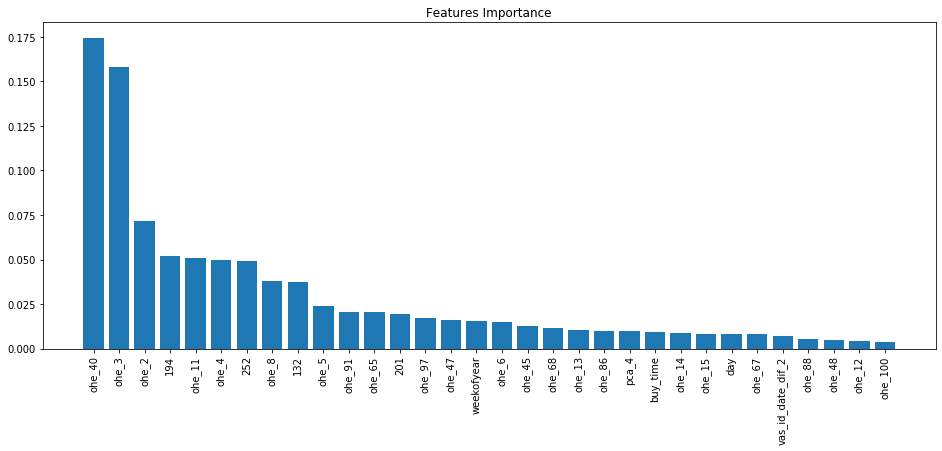

TRAIN

              precision    recall  f1-score   support

         0.0       0.96      0.95      0.95    385733
         1.0       0.84      0.88      0.86    124747

    accuracy                           0.93    510480
   macro avg       0.90      0.91      0.91    510480
weighted avg       0.93      0.93      0.93    510480



CONFUSION MATRIX TRAIN


col_0      0.0     1.0
target                
0.0     365425   20308
1.0      15431  109316


TEST

              precision    recall  f1-score   support

         0.0       0.98      0.95      0.96    385734
         1.0       0.52      0.72      0.60     30093

    accuracy                           0.93    415827
   macro avg       0.75      0.83      0.78    415827
weighted avg       0.94      0.93      0.94    415827



CONFUSION MATRIX TEST


col_0      0.0    1.0
target               
0.0     365759  19975
1.0       8571  21522


In [453]:
n=32
feature_importance = plot_importance(clf1.feature_importances_, X_train_balanced_xg.columns, 'Features Importance', n)

# перестроили модель с наилучшими столбцами
X_train_FI = pd.DataFrame(X_train_balanced_xg, columns=X_train_balanced_xg.columns)[feature_importance[0][:n]]
X_test_FI = pd.DataFrame(X_test_xg, columns=X_test_xg.columns)[feature_importance[0][:n]]


clf3,y_train_pred_xg_1,y_test_pred_xg_1,y_test_pred_probas_xg_1 = xgboost_predict(X_train_FI, y_train_balanced,X_test_FI, y_test)

In [454]:
evaluation(y_test, y_test_pred_xg_1, y_test_pred_probas_xg_1)

Precision: 0.5186399016796395
Recall: 0.7151829329079853
F1: 0.6012571588210643
Log Loss: 0.1449411202700627
ROC AUC: 0.9506665024759771


## Сравнение моделей

y_test_pred_xg: AUC_PR = 0.683
y_test_pred_xg: AUC_ROC = 0.951


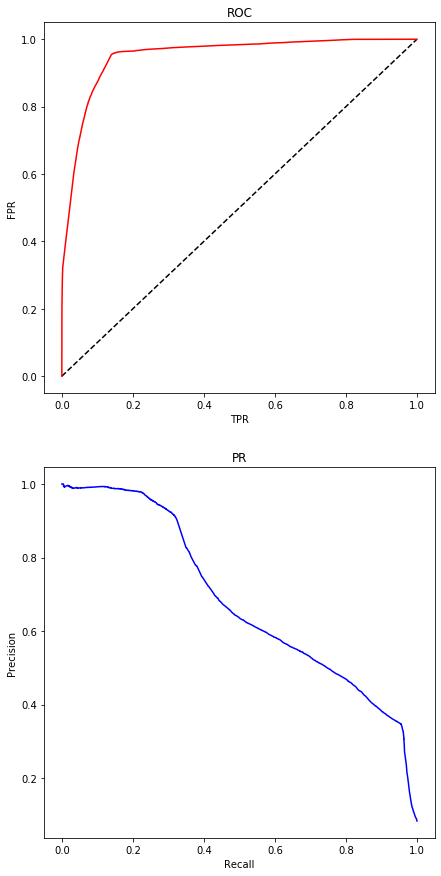

In [444]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

f.set_figheight(15)
f.set_figwidth(7)

ax1 = plt.subplot(211)
ax1.set_title('ROC')
ax1.set_xlabel('TPR')
ax1.set_ylabel('FPR')


ax2 = plt.subplot(212)
ax2.set_title('PR')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')

ax1.plot([0, 1], [0, 1], 'k--')


fpr, tpr, roc_thresholds = roc_curve(y_test, y_test_pred_probas_xg_1)
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_test_pred_probas_xg_1)
ax1.plot(fpr, tpr, label="xgboost", color='r')
ax2.plot(recall, precision, label="xgboost", color='b')
print("y_test_pred_xg: AUC_PR = %.3f" % auc(recall, precision))
print("y_test_pred_xg: AUC_ROC = %.3f" % auc(fpr, tpr))

y_test_pred_lg: AUC_PR = 0.676
y_test_pred_lg: AUC_ROC = 0.949


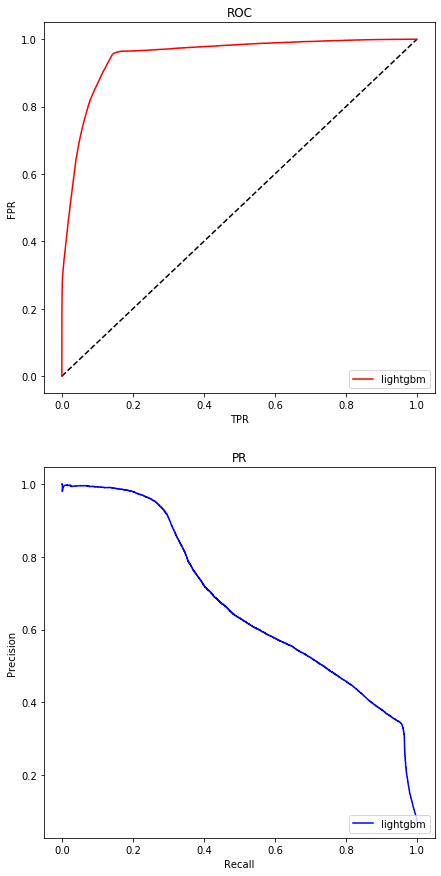

In [390]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

f.set_figheight(15)
f.set_figwidth(7)

ax1 = plt.subplot(211)
ax1.set_title('ROC')
ax1.set_xlabel('TPR')
ax1.set_ylabel('FPR')


ax2 = plt.subplot(212)
ax2.set_title('PR')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')

ax1.plot([0, 1], [0, 1], 'k--')


fpr, tpr, roc_thresholds = roc_curve(y_test, y_test_pred_probas_lg)
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_test_pred_probas_lg)
ax1.plot(fpr, tpr, label="lightgbm", color='r')
ax2.plot(recall, precision, label="lightgbm", color='b')
print("y_test_pred_lg: AUC_PR = %.3f" % auc(recall, precision))
print("y_test_pred_lg: AUC_ROC = %.3f" % auc(fpr, tpr))
ax1.legend(loc="lower right")
ax2.legend(loc="lower right");

y_test_pred_xg: AUC_PR = 0.683
y_test_pred_xg: AUC_ROC = 0.951
y_test_pred_lg: AUC_PR = 0.676
y_test_pred_lg: AUC_ROC = 0.949


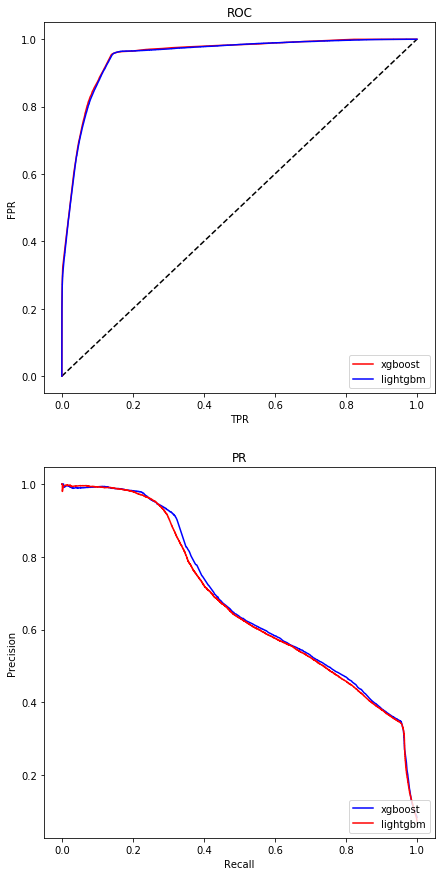

In [445]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

f.set_figheight(15)
f.set_figwidth(7)

ax1 = plt.subplot(211)
ax1.set_title('ROC')
ax1.set_xlabel('TPR')
ax1.set_ylabel('FPR')


ax2 = plt.subplot(212)
ax2.set_title('PR')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')

ax1.plot([0, 1], [0, 1], 'k--')

fpr, tpr, roc_thresholds = roc_curve(y_test, y_test_pred_probas_xg_1)
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_test_pred_probas_xg_1)
ax1.plot(fpr, tpr, label="xgboost", color='r')
ax2.plot(recall, precision, label="xgboost", color='b')
print("y_test_pred_xg: AUC_PR = %.3f" % auc(recall, precision))
print("y_test_pred_xg: AUC_ROC = %.3f" % auc(fpr, tpr))


fpr, tpr, roc_thresholds = roc_curve(y_test, y_test_pred_probas_lg)
precision, recall, pr_thresholds = precision_recall_curve(y_test, y_test_pred_probas_lg)
ax1.plot(fpr, tpr, label="lightgbm", color='b')
ax2.plot(recall, precision, label="lightgbm", color='r')
print("y_test_pred_lg: AUC_PR = %.3f" % auc(recall, precision))
print("y_test_pred_lg: AUC_ROC = %.3f" % auc(fpr, tpr))
ax1.legend(loc="lower right")
ax2.legend(loc="lower right");

## предсказание результата

In [456]:
# n определено выше n=32
X_test_res_FI = pd.DataFrame(X_test_res, columns=X_test_res.columns)[feature_importance[0][:n]]

In [457]:
predict_test = clf3.predict(X_test_res_FI)
predict_proba_test = clf3.predict_proba(X_test_res_FI)

In [458]:
# buy_time, id, vas_id и target
# Target можно записать как вероятность подключения услуги.
result = pd.concat([test_res['buy_time'],test_res['id'],test_res['vas_id'], pd.Series(predict_proba_test[:,1])], axis=1)

In [461]:
result = result.rename(columns={0: 'target'})

In [462]:
result.head()

,buy_time,id,vas_id,target
0,1548018000,3130519,2.0,0.541791
1,1548018000,2000860,4.0,0.640327
2,1546808400,1099444,2.0,0.677449
3,1547413200,1343255,5.0,0.026890
4,1546808400,1277040,2.0,0.592477


In [463]:
result.to_csv('IMarchenko_predictions_05.06.csv',index=None)

## Сохраниение модели

In [465]:
filename = 'final_model.sav'
pickle.dump(clf3, open(filename, 'wb'))
